In [23]:
import numpy as np
from matplotlib import pyplot as plt
from ncon import ncon
from scipy import interpolate
import scipy.io

file_path = 'down_s3_D5(1).mat'
mat = scipy.io.loadmat(file_path)
tck_en   = interpolate.splrep(np.concatenate(([0],mat['J_tab'].T[0])),np.concatenate(([0],mat['en_tab'].T[0])))
tck_n    = interpolate.splrep(np.concatenate(([0],mat['J_tab'].T[0])),np.concatenate(([1],mat['n_tab'].T[0])))
tck_varn = interpolate.splrep(np.concatenate(([0],mat['J_tab'].T[0])),np.concatenate(([0],mat['varn_tab'].T[0])))
tck_C1   = interpolate.splrep(np.concatenate(([0],mat['J_tab'].T[0])),np.concatenate(([0],mat['C1_tab'].T[0])))

def GEnergy_from_J(J):
    return interpolate.splev(J, tck_en)
def GN_from_J(J):
    return interpolate.splev(J, tck_n)
def GVarN_from_J(J):
    return interpolate.splev(J, tck_varn)
def GC1_from_J(J):
    return interpolate.splev(J, tck_C1)

def GetData(d,D,k,chimult):
    # iter     time           tQ
    # J        U              k
    # n        błędy z CTM    błędy pomiędzy oczkami A i B
    # n2
    # AA
    # En
    # En-Eg
    # NN
    data = []
    try:
        SPECS = dict(np.load(f"./all_bh_ramps/BH-cubicramp_{d}_{D}_{k:.1f}_0.1/SPECS.npz"))
        finaliter = int(3/2*SPECS['tQ']/SPECS['dt']+0.0001) + 1
        # print(D,k,"\t\t",int(3/2*SPECS['tQ']/SPECS['dt']+0.0001))
        env = dict(np.load(f"./all_bh_ramps/BH-cubicramp_{d}_{D}_{k:.1f}_0.1/RHOA_{chimult}_{finaliter:05d}.npz"))
    except: raise Exception("aaa")
    for i in range(0,finaliter+1):
        try:
            env = dict(np.load(f"./all_bh_ramps/BH-cubicramp_{d}_{D}_{k:.1f}_0.1/RHOA_{chimult}_{i:05d}.npz"))
        except:
            break
        U,J=env['U'],env['J']
        m = [[env['iter'],env['iter']*env['dt'],0.1*2**(k/10)],[J,U,k]]
        # name mean syst_error std_error
        for iter in range(len(env['names1'])):
            m.append([np.real_if_close(np.mean(env['vals1'][iter])), np.real_if_close(np.mean(env['errors1'][iter])), np.real_if_close(np.std(env['vals1'][iter]))])
        for iter in range(len(env['names2'])):
            m.append([np.real_if_close(np.mean(env['vals2'][iter])), np.real_if_close(np.mean(env['errors2'][iter])), np.real_if_close(np.std(env['vals2'][iter]))])
        m = np.array(m)
        M = np.array([[1,0,0,0,0,0,0],[0,1,0,0,0,0,0],[0,0,1,0,0,0,0],[0,0,0,1,0,0,0],[0,0,0,0,1,1,0],[0,0,-U/2,U/2,-2*J,-2*J,0],[0,0,-U/2,U/2,-2*J,-2*J,0],[0,0,0,0,0,0,1]])
        m = ncon([M,m],([-1,1],[1,-2]))
        m[6,0] -= GEnergy_from_J(J)
        data.append(m)
    data = np.array(data)
    return np.real_if_close(data)

def LinearInterpolate(x1,x2,y1,y2,x):
    y1 = np.array(y1)
    y2 = np.array(y2)
    val = (x*y1 - x2*y1 - x*y2 + x1*y2)/(x1 - x2)
    err = np.abs(y2 - y1) / 2
    return [val, err]

def GetCriticalData(d,D,k,chimult):
    ic = 3/2*2**(k/10)
    i1, i2 = int(np.floor(ic)), int(np.ceil(ic))
    m = []
    if i1==i2:
        env1 = dict(np.load(f"./all_bh_ramps/BH-cubicramp_{d}_{D}_{k:.1f}_0.1/RHOA_{chimult}_{i1:05d}.npz"))
        for yhj in ["1","2"]:
            for i in range(len(env1['names'+yhj])):
                mean1 = np.real_if_close(np.mean(env1['vals'+yhj][i]))
                name1 = env1['names'+yhj][i]
                m.append([name1, mean1, 0])
    else:
        env1 = dict(np.load(f"./all_bh_ramps/BH-cubicramp_{d}_{D}_{k:.1f}_0.1/RHOA_{chimult}_{i1:05d}.npz"))
        env2 = dict(np.load(f"./all_bh_ramps/BH-cubicramp_{d}_{D}_{k:.1f}_0.1/RHOA_{chimult}_{i2:05d}.npz"))
        for yhj in ["1","2"]:
            for i in range(len(env1['names'+yhj])):
                mean1 = np.real_if_close(np.mean(env1['vals'+yhj][i]))
                name2 = env2['names'+yhj][i]
                mean2 = np.real_if_close(np.mean(env2['vals'+yhj][i]))
                print(f'{name2}\t{(mean1+mean2)/2:.04f}\t{(mean1-mean2)}')
                interpolation=LinearInterpolate(i1,i2,mean1,mean2,ic)
                m.append([name2, interpolation[0], interpolation[1]])
    m[2][0]='AA'
    m[2][1] += m[3][1]
    m[2][2] += m[3][2]
    m.pop(3)
    return np.real_if_close(np.array(m))

def  GetCspCritical(D,k,d,chimult):
    ic=3/2*2**(k/10);
    i1, i2 = int(np.floor(ic)), int(np.ceil(ic))
    if (i1 == i2):
        corAAH = dict(np.load(f"./DATA/BH-cubicramp_{d}_{D}_{k:.1f}_0.1/CORR_{chimult}_AAH_NS_{i1:05d}.npz"))
        corAHA = dict(np.load(f"./DATA/BH-cubicramp_{d}_{D}_{k:.1f}_0.1/CORR_{chimult}_AHA_NS_{i1:05d}.npz"))
        AA_A = corAAH['corA'] + corAHA['corA']
        AA_B = corAAH['corB'] + corAHA['corB']
        return (AA_A+AA_B)/2, np.abs(AA_A-AA_B)/2
    else:
        corAAH1 = dict(np.load(f"./DATA/BH-cubicramp_{d}_{D}_{k:.1f}_0.1/CORR_{chimult}_AAH_NS_{i1:05d}.npz"))
        corAHA1 = dict(np.load(f"./DATA/BH-cubicramp_{d}_{D}_{k:.1f}_0.1/CORR_{chimult}_AHA_NS_{i1:05d}.npz"))
        AA_A1 = corAAH1['corA'] + corAHA1['corA']
        AA_B1 = corAAH1['corB'] + corAHA1['corB']
        corAAH2 = dict(np.load(f"./DATA/BH-cubicramp_{d}_{D}_{k:.1f}_0.1/CORR_{chimult}_AAH_NS_{i2:05d}.npz"))
        corAHA2 = dict(np.load(f"./DATA/BH-cubicramp_{d}_{D}_{k:.1f}_0.1/CORR_{chimult}_AHA_NS_{i2:05d}.npz"))
        AA_A2 = corAAH2['corA'] + corAHA2['corA']
        AA_B2 = corAAH2['corB'] + corAHA2['corB']
        AA_A, error_A = LinearInterpolate(i1, i2, AA_A1, AA_A2, ic)
        AA_B, error_B = LinearInterpolate(i1, i2, AA_B1, AA_B2, ic)
        AA = (AA_A+AA_B)/2
        error1 = np.abs(error_A+error_B)/2
        error2 = np.abs(AA_A-AA_B)/2
        error = np.where(error1>error2,error1,error2)
        return AA, error

def ar(i_around): return np.arange(np.floor(i_around)-1,np.ceil(i_around)+2)

In [43]:
y,yerr=GetCspCritical(6,50,3,2)
x = np.arange(0,y.shape[0])
for d in [3,4,5]:
    for D in [4,6,8,10,12,14,16,18,20,22,24]:
        for k in np.arange(5,130,5):
            for chimult in [2,3,4,5]:
                try: csp,csperr = GetCspCritical(D,k,d,chimult)
                except: continue
                print(f"{D}\t\t{k}\t\t{chimult}")
                np.savetxt(f"BHcritical_{d}_{D}_{k}_{chimult}.txt",np.array([csp,csperr]).T,delimiter=',')
                # f = open(f"BHcritical_{d}_{D}_{k}_{chimult}")
                # f.write(string)

4		5		2
4		10		2
4		10		3
4		10		4
4		15		2
4		20		2
4		20		3
4		20		4
4		25		2
4		30		2
4		30		3
4		30		4
4		35		2
4		40		2
4		40		3
4		40		4
4		45		2
6		10		2
6		10		3
6		10		4
6		20		2
6		20		3
6		20		4
6		30		2
6		30		3
6		30		4
6		40		2
6		40		3
6		40		4
6		50		2
6		50		3
6		50		4
8		5		2
8		10		2
8		10		3
8		10		4
8		15		2
8		20		2
8		20		3
8		20		4
8		25		2
8		30		2
8		30		3
8		30		4
8		35		2
8		40		2
8		40		3
8		40		4
8		45		2
8		50		2
8		50		3
8		50		4
8		55		2
8		60		2
8		60		3
8		60		4
10		10		2
10		10		3
10		10		4
10		20		2
10		20		3
10		20		4
10		30		2
10		30		3
10		30		4
10		40		2
10		40		3
10		40		4
10		50		2
10		50		3
10		50		4
10		60		2
10		60		3
10		60		4
12		10		2
12		10		3
12		10		4
12		20		2
12		20		3
12		20		4
12		30		2
12		30		3
12		30		4
12		40		2
12		40		3
12		40		4
12		50		2
12		50		3
12		50		4
12		60		2
12		60		3
12		70		2
14		10		2
14		10		3
14		20		2
14		20		3
14		30		2
14		30		3
14		40		2
14		40		3
14		50		2
14		50		3
14		60		2
14		60		3


In [108]:
for i,name in enumerate(['N','N2','Csp1','NN']):
    file = open(f"BHcritical_{name}.txt",'w')
    for k in [10,20,30,40,50,60]:
        for D in [4,6,8,10]:
            try: data = (GetCriticalData(3,D,k,2))
            except: continue
            print(f'{name}\t{k}\t{D} \t{float(complex(data[i][1]).real):.08f}\t{data[i][2]}')
            file.write(f'{k}\t{D} \t{float(complex(data[i][1]).real)}\t{float(abs(complex(data[i][2])))}\n')
    file.close()

N	10	4 	1.00000000	0
N	10	6 	1.00000000	0
N	10	8 	1.00000000	0
N	10	10 	1.00000000	0
N	20	4 	1.00000000	0
N	20	6 	1.00000000	0
N	20	8 	1.00000000	0
N	20	10 	1.00000000	0
N	30	4 	1.00000000	0
N	30	6 	1.00000000	0
N	30	8 	1.00000000	0
N	30	10 	1.00000000	0
N	40	4 	1.00000005	0
N	40	6 	1.00000006	0
N	40	8 	1.00000002	0
N	40	10 	1.00000002	0
N	50	6 	0.99999883	0
N	50	8 	1.00000008	0
N	50	10 	1.00000002	0
N	60	8 	1.00000763	0
N	60	10 	1.00001274	0
N2	10	4 	1.00072275	0
N2	10	6 	1.00072275	0
N2	10	8 	1.00072275	0
N2	10	10 	1.00072275	0
N2	20	4 	1.00285534	0
N2	20	6 	1.00285541	0
N2	20	8 	1.00285541	0
N2	20	10 	1.00285541	0
N2	30	4 	1.01086947	0
N2	30	6 	1.01087091	0
N2	30	8 	1.01087088	0
N2	30	10 	1.01087086	0
N2	40	4 	1.03574439	0
N2	40	6 	1.03576381	0
N2	40	8 	1.03576258	0
N2	40	10 	1.03576226	0
N2	50	6 	1.06910734	0
N2	50	8 	1.06908542	0
N2	50	10 	1.06908191	0
N2	60	8 	1.06544216	0
N2	60	10 	1.06553455	0
Csp1	10	4 	0.00469282	0
Csp1	10	6 	0.00469291	0
Csp1	10	8 	0.00469290	0
Csp1	10	10 	0

In [83]:
data[:,3,0]-1

array([0.00000000e+00, 1.96579074e-05, 8.06785409e-04])

In [14]:
for k in range(-1000,3000):
    i = 3/2*2**(k/10)
    if not (int(np.floor(i))<= i <= int(np.ceil(i))):
        print(k,"\t  ",int(np.floor(i)),"\t",f"{i:.04f}","\t", int(np.ceil(i)),"\t",int(np.floor(i))<= i <= int(np.ceil(i)))

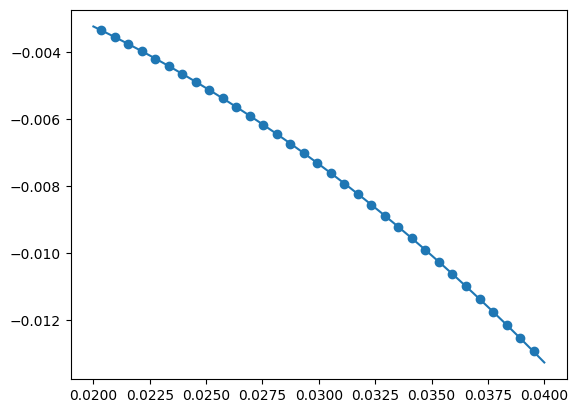

In [73]:
Jsc = np.linspace(0.02,0.04,1000)
Jsd = np.concatenate(([0],mat['J_tab'].T[0]))
inds=np.logical_and(Jsc.min() <= Jsd, Jsd <= Jsc.max())
plt.plot(Jsc,GEnergy_from_J(Jsc))
plt.scatter(Jsd[inds],GEnergy_from_J(Jsd[inds]))

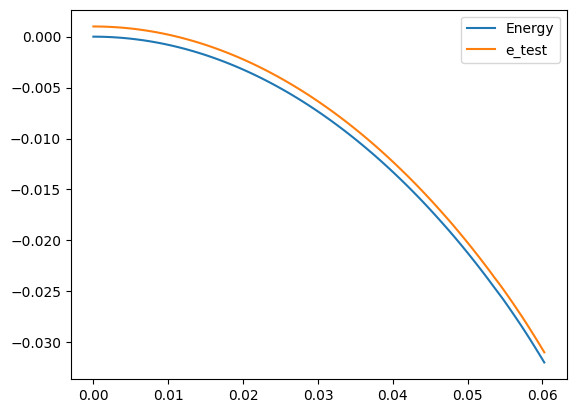

In [14]:
Js = np.linspace(0,1/16.6,100,endpoint=True)
ges, gns, gvarns, gc1s = GEnergy_from_J(np.array(Js)),GN_from_J(np.array(Js)),GVarN_from_J(np.array(Js)),GC1_from_J(np.array(Js))
plt.plot(Js,ges,label='Energy')
plt.plot(Js,0.001+gvarns/2-2*Js*gc1s,label='e_test')
plt.legend()
# plt.scatter(np.concatenate(([0],mat['J_tab'].T[0])),np.concatenate(([0],mat['en_tab'].T[0])))

In [3]:
SPECS = dict(np.load("./all_bh_ramps/BH-cubicramp_3_4_10.0_0.1/SPECS.npz"))
print(SPECS)

{'NTUprecision': array(1.e-15), 'NTUprecisionspeed': array(0), 'maxiter': array(50), 'dt': array(0.1), 'd': array(3), 'D': array(4), 'r': array(9), 'tQ': array(0.2)}


In [45]:
env = dict(np.load("./all_bh_ramps/BH-cubicramp_3_4_30.0_0.1/RHOA_2_00004.npz"))
print(list(env))

['rhoA', 'rhoB', 'E_E_A', 'E_E_B', 'E_W_A', 'E_W_B', 'E_S_A', 'E_S_B', 'E_N_A', 'E_N_B', 'C_NW_A', 'C_SW_B', 'C_NE_B', 'C_SE_A', 'C_NW_B', 'C_SW_A', 'C_NE_A', 'C_SE_B', 'error', 'iter', 'dt', 'A', 'B', 'J', 'U', 'names1', 'names2', 'vals1', 'vals2', 'errors1', 'errors2', 'INVprecision', 'CTMRGprecision']


In [42]:
def GetData(d,D,k,chimult):
    # iter     time           tQ
    # J        U              k
    # n        błędy z CTM    błędy pomiędzy oczkami A i B
    # n2
    # AA
    # En
    # En-Eg
    # NN
    data = []
    try:
        SPECS = dict(np.load(f"./all_bh_ramps/BH-cubicramp_{d}_{D}_{k:.1f}_0.1/SPECS.npz"))
        finaliter = int(3/2*SPECS['tQ']/SPECS['dt']+0.0001) + 1
        # print(D,k,"\t\t",int(3/2*SPECS['tQ']/SPECS['dt']+0.0001))
        env = dict(np.load(f"./all_bh_ramps/BH-cubicramp_{d}_{D}_{k:.1f}_0.1/RHOA_{chimult}_{finaliter:05d}.npz"))
    except: raise Exception("aaa")
    for i in range(0,finaliter+1):
        try:
            env = dict(np.load(f"./all_bh_ramps/BH-cubicramp_{d}_{D}_{k:.1f}_0.1/RHOA_{chimult}_{i:05d}.npz"))
        except:
            break
        U,J=env['U'],env['J']
        m = [[env['iter'],env['iter']*env['dt'],0.1*2**(k/10)],[J,U,k]]
        # name mean syst_error std_error
        for iter in range(len(env['names1'])):
            m.append([np.real_if_close(np.mean(env['vals1'][iter])), np.real_if_close(np.mean(env['errors1'][iter])), np.real_if_close(np.std(env['vals1'][iter]))])
        for iter in range(len(env['names2'])):
            m.append([np.real_if_close(np.mean(env['vals2'][iter])), np.real_if_close(np.mean(env['errors2'][iter])), np.real_if_close(np.std(env['vals2'][iter]))])
        m = np.array(m)
        M = np.array([[1,0,0,0,0,0,0],[0,1,0,0,0,0,0],[0,0,1,0,0,0,0],[0,0,0,1,0,0,0],[0,0,0,0,1,1,0],[0,0,-U/2,U/2,-2*J,-2*J,0],[0,0,-U/2,U/2,-2*J,-2*J,0],[0,0,0,0,0,0,1]])
        m = ncon([M,m],([-1,1],[1,-2]))
        m[6,0] -= GEnergy_from_J(J)
        data.append(m)
    data = np.array(data)
    return np.real_if_close(data)

In [43]:
drr = GetData(3,10,40,2)

In [44]:
print(np.real_if_close(drr[14,:,:]))
print(np.array2string(drr[14,0,0]))
print(np.array2string(drr[14,1,0]))
print(np.array2string(drr[14,6,0]))
print(np.array2string(drr[14,0,0])+"\t"+np.array2string(drr[14,1,0])+"\t"+np.array2string(drr[14,6,0]))

[[ 1.40000000e+01  1.40000000e+00  1.60000000e+00]
 [ 2.15952643e-02  1.00000000e+00  4.00000000e+01]
 [ 1.00000000e+00  3.33066907e-16  5.72885073e-11]
 [ 1.00219606e+00 -4.44089210e-16  3.46629836e-10]
 [ 3.30604049e-02 -8.67361738e-19  1.17873466e-05]
 [-3.29865009e-04 -3.88540597e-16 -5.08957061e-07]
 [ 3.43851795e-03 -3.88540597e-16 -5.08957061e-07]
 [ 9.99451598e-01  5.82867088e-16  3.97474778e-07]]
14.
0.02159526
0.00343852
14.	0.02159526	0.00343852


In [46]:
d=3
# for D in [10]:
#     for k in [60]:
for D in [4,6,8,10,12,14]:
    for k in [10,20,30,40,50,60,70,80,90,100]:
        chimult=2
        try: drr = GetData(d,D,k,2)
        except: continue

        f = open(f"./BH-cubicramp_{d}_{D}_{k:.1f}_0.1.txt","w")
        for i0 in range(0,drr.shape[0]):
            print(i0,"\t\t",drr[i0,:,:])
            t = i0*0.1 - 3/2*0.1*2**(k/10)
            for i1 in range(0,drr.shape[1]):
                f.write(np.array2string(drr[i0,i1,:])+"\n")
        f.close()

        f = open(f"./BH-cubicramp-onlyground_{d}_{D}_{k:.1f}_0.1.txt","w")
        for i0 in range(0,drr.shape[0]):
            print(np.array2string(drr[i0,0,0])+"\t"+np.array2string(drr[i0,1,0])+"\t"+np.array2string(drr[i0,6,0]))
            f.write(np.array2string(drr[i0,0,0])+"\t"+np.array2string(drr[i0,1,0])+"\t"+np.array2string(drr[i0,6,0])+"\n")
        f.close()

0 		 [[ 0.   0.   0.2]
 [ 0.   1.  10. ]
 [ 1.   0.   0. ]
 [ 1.   0.   0. ]
 [ 0.   0.   0. ]
 [ 0.   0.   0. ]
 [ 0.   0.   0. ]
 [ 1.   0.   0. ]]
1 		 [[ 1.00000000e+00  1.00000000e-01  2.00000000e-01]
 [-2.65921683e-17  1.00000000e+00  1.00000000e+01]
 [ 1.00000000e+00  1.11022302e-16  4.65738890e-14]
 [ 1.00000149e+00  0.00000000e+00  9.31477779e-14]
 [ 1.21877306e-04  1.94817578e-19  4.36435353e-08]
 [ 7.43324124e-07 -5.55111512e-17  2.32869445e-14]
 [ 7.43324124e-07 -5.55111512e-17  2.32869445e-14]
 [ 9.99999628e-01 -2.77555756e-17  2.66174021e-10]]
2 		 [[ 2.00000000e+00  2.00000000e-01  2.00000000e-01]
 [ 8.87114660e-03  1.00000000e+00  1.00000000e+01]
 [ 1.00000000e+00 -1.66533454e-16  4.07707201e-12]
 [ 1.00007854e+00 -1.11022302e-16  8.14448509e-12]
 [ 1.12885769e-03  6.50521303e-19  4.05506297e-07]
 [ 1.92390210e-05  2.77440339e-17 -7.19257791e-09]
 [ 6.49859627e-04  2.77440339e-17 -7.19257791e-09]
 [ 9.99980367e-01 -2.77555756e-17  1.41549638e-08]]
3 		 [[ 3.00000000e+00

/home/jmazur/.local/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


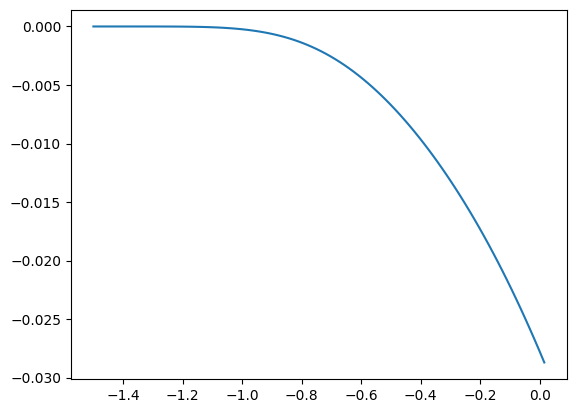

In [80]:
k=60
data = GetData(3, 10, k, 2)
ts = (data[:,0,1] - 3/2*data[0,0,2])/data[0,0,2]
es = data[:,4,0]
plt.plot(ts,es)

In [3]:
d=dict(np.load("./BH-cubicramp/BH-cubicramp_3_4_10_0.1/PEPS_00001.npz"))

['__header__', '__version__', '__globals__', 'J_tab', 'C1_tab', 'n_tab', 'varn_tab', 'en_tab']


In [2]:
i=1
for i in range(10000000):
    try:
        d=dict(np.load(f"./BH-cubicramp/BH-cubicramp_3_4_20_0.1/PEPS_{i:05d}.npz"))
        print('status' in d)
    except: break

True
True
True
True
True
True
True
True


In [29]:
n=np.diag([0,1,2])
for i in range(10000000):
    try:
        d1=dict(np.load(f"./BH-cubicramp_3_4_30.0_0.1-test/PEPS_{i:05d}.npz"))
        d2=dict(np.load(f"./BH-cubicramp_3_4_30.0_0.1/PEPS_{i:05d}.npz"))
        A1 = d1['A']
        A2 = d2['A']
        A1 = A1 / np.linalg.norm(A1) / A1[0,0,0,0,1]
        A2 = A2 / np.linalg.norm(A2) / A2[0,0,0,0,1]
        n1=ncon([A1, A1.conj(),n],([1,2,3,4,5],[1,2,3,4,6],[5,6]))
        n2=ncon([A2, A2.conj(),n],([1,2,3,4,5],[1,2,3,4,6],[5,6]))
        print(n1-n2,"\t",np.linalg.norm(A1-A2))
    except: break

0j 	 0.0
(6.661338147750939e-16+0j) 	 0.02279494131388548
(-5.089262344881718e-13+0j) 	 0.07731003073949101
(-1.3022698874820549e-07+0j) 	 0.10629341753550918
(-1.4968691286476599e-07+0j) 	 0.17654709112459627
(4.397181507798109e-08+0j) 	 0.24944304559110878
(3.684989617891432e-07+0j) 	 0.2748425914972807
(1.2483731794965536e-06+0j) 	 0.4070453517109724
(3.3251803326361795e-06+0j) 	 0.4538964031207468
(8.251106622614302e-06+0j) 	 0.5374765237205391
(1.898398826161163e-05+0j) 	 0.6080492860053037
(4.039302364744479e-05+0j) 	 0.714760061778417
(8.005403658373211e-05+0j) 	 0.8300527538365295
(0.00014889970739773162+0j) 	 0.9138865507373856
(0.000262005081146377+0j) 	 0.9350922518119397


In [27]:
A1.shape

(4, 4, 4, 4, 3)

In [38]:
dict(np.load("./alldata/BH-cubicramp_3_14_70.0_0.1/PEPS_00132.npz"))

FileNotFoundError: [Errno 2] No such file or directory: './alldata/BH-cubicramp_3_14_70.0_0.1/PEPS_00132.npz'